<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitaldb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VitalDB 데이터 셋 이용
오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요. 

## 필요한 헤더

In [24]:
import pandas as pd
import numpy as np

## 임상 정보 받아오기

In [25]:
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases

,caseid,death_inhosp,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,devices,tracks,casedur,filesize,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,opdur,anedur,los_postop,los_icu,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_spo2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,0,0,11520,-540,10860,-540,10380,-236220,627780,4,78,192,21.3,77.0,M,160.2,67.50,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,145,180,8,0,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Left radial,N,N,N,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,0,0,15720,-1020,14940,1740,14640,-221160,1506840,5,75,262,26.3,54.0,M,167.3,54.80,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,215,245,19,0,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,0,0,4440,-540,4260,-540,3960,-218640,40560,5,80,73,6.6,62.0,M,169.1,69.70,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,32,65,2,0,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,0,0,21000,-720,20280,2580,18180,-201120,576480,5,74,350,28.3,74.0,M,160.6,53.00,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,255,335,7,1,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,N,Right radial,N,N,N,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,0,0,21540,-960,22440,2640,21840,-67560,3734040,6,99,359,41.0,66.0,M,171.0,59.70,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,295,350,45,13,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Right radial,N,Right IJV,N,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,0,0,15240,-240,15660,-240,15060,-215340,648660,5,73,254,9.3,64.0,M,161.5,63.00,24.2,1.0,0,General surgery,Stomach,Advanced gastric cancer,Total gastrectomy,Open,Supine,General,200,245,8,0,0,0,Normal Sinus Rhythm,Normal,14.5,279.0,109.0,31.0,NaN,NaN,100.0,4.2,31.0,33.0,13.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,100.0,330.0,0,0,550.0,0,150,0.0,0,90,0,20,0,0,0
6384,6385,0,0,20640,-540,21000,-540,19800,-225600,1675200,5,76,344,29.0,69.0,M,159.3,62.30,24.6,2.0,0,General surgery,Colorectal,"Colon submucosal tumor, unknown behavior",Ultralow anterior resection,Videoscopic,Lithotomy,General,285,335,20,0,1,0,Normal Sinus Rhythm,Normal,15.2,239.0,114.0,28.7,144.0,4.0,140.0,3.7,18.0,28.0,19.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,Right forearm,Left forearm,Right radial,N,N,N,100.0,250.0,0,0,2500.0,0,100,0.0,0,

### 임상 정보 결측률 확인

In [26]:
print((df_cases.isnull().mean() * 100).to_string())

caseid                  0.000000
death_inhosp            0.000000
casestart               0.000000
caseend                 0.000000
anestart                0.000000
aneend                  0.000000
opstart                 0.000000
opend                   0.000000
adm                     0.000000
dis                     0.000000
devices                 0.000000
tracks                  0.000000
casedur                 0.000000
filesize                0.000000
age                     0.000000
sex                     0.000000
height                  0.000000
weight                  0.000000
bmi                     0.000000
asa                     2.082029
emop                    0.000000
department              0.000000
optype                  0.000000
dx                      0.000000
opname                  0.000000
approach                0.000000
position                3.036944
ane_type                0.000000
opdur                   0.000000
anedur                  0.000000
los_postop

## 트랙 정보 받아오기

In [27]:
df_trks = pd.read_csv("https://api.vitaldb.net/trks")
df_trks

,caseid,tname,tid
0,1,BIS/BIS,fd869e25ba82a66cc95b38ed47110bf4f14bb368
1,1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
2,1,BIS/EEG2_WAV,ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3,1,BIS/EMG,2525603efe18d982764dbca457affe7a45e766a9
4,1,BIS/SEF,1c91aec859304840dec75acf4a35da78be0e8ef0
...,...,...,...
537036,6388,Solar8000/VENT_PIP,2d63adbc7e2653f14348e219816673cde3358cf6
537037,6388,Solar8000/VENT_PPLAT,6f6604255858ddc8f6a01b9f4774b0d43105f6da
537038,6388,Solar8000/VENT_RR,f34f3fae7fd963355c1c7060e1e876d20fa87536
537039,6388,Solar8000/VENT_SET_TV,4a4a55b8aebf9c76a4a76f62a7c1ec6fcb80e618


### 트랙 정보 취득률 확인

In [28]:
for tname in sorted(df_trks['tname'].unique()):
    print('{}\t{}'.format(tname, (df_trks['tname'] == tname).sum() / len(df_cases) * 100))


/EVENT	29.852849092047588
BIS/BIS	91.85973700688791
BIS/EEG1_WAV	91.92235441452723
BIS/EEG2_WAV	91.92235441452723
BIS/EMG	87.31997495303695
BIS/SEF	87.1947401377583
BIS/SQI	91.85973700688791
BIS/SR	87.1947401377583
BIS/TOTPOW	86.91296180338134
CardioQ/ABP	0.4539762053850971
CardioQ/CI	0.4383218534752661
CardioQ/CO	0.4539762053850971
CardioQ/FLOW	0.4539762053850971
CardioQ/FTc	0.4539762053850971
CardioQ/FTp	0.4383218534752661
CardioQ/HR	0.4539762053850971
CardioQ/MA	0.4383218534752661
CardioQ/MD	0.4539762053850971
CardioQ/PV	0.4383218534752661
CardioQ/SD	0.4539762053850971
CardioQ/SV	0.4539762053850971
CardioQ/SVI	0.4383218534752661
CardioQ/SVR	0.015654351909830933
EV1000/ART_MBP	9.267376330619912
EV1000/CI	9.658735128365684
EV1000/CO	9.658735128365684
EV1000/CVP	3.678772698810269
EV1000/SCVO2	0.015654351909830933
EV1000/SQI	0.015654351909830933
EV1000/SV	9.658735128365684
EV1000/SVI	9.658735128365684
EV1000/SVR	3.991859737006888
EV1000/SVRI	3.991859737006888
EV1000/SVV	9.65873512836568

In [29]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['age'] > 18]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print(len(caseids))

3452


## 트랙 ID (tid) 구하기
VitalDB 데이터의 실제 트랙 데이터를 사용하기 위해서는 해당 트랙의 트랙 ID (tid)가 반드시 필요하다.
* tid 는 caseid 와 트랙명으로부터 구한다.
* 트랙명의 리스트는 https://vitaldb.net/data-bank/?query=param

In [30]:
caseid = 6388
tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
tid

'8132234ea9f472b48d012f50892cd495de3871c9'

## 검사 결과 데이터 로딩

In [31]:
labs = pd.read_csv('https://api.vitaldb.net/labs')
labs

,caseid,dt,name,result
0,1867,143869,Calcium,8.70
1,1867,143869,Phosphorus,3.20
2,1867,143869,BUN,10.00
3,1867,143869,Uric Acid,7.10
4,1867,143869,"Protein, total",7.30
...,...,...,...,...
1276506,3549,12900803,Creatinine,4.77
1276507,3549,12900803,Sodium,134.00
1276508,3549,12900803,Potassium,3.50
1276509,3549,12900803,Chloride,111.00


# vitaldb 라이브러리를 이용하여 트랙을 받아오는 방법
github에 공개된 vitaldb 라이브러리를 이용하여 vitaldb 트랙들을 읽어옵니다.

먼저 vitaldb 라이브러리를 다운로드 합니다.

In [32]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

import vitaldb

--2021-04-17 04:30:35--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17039 (17K) [text/plain]
Saving to: ‘vitaldb.py.2’

vitaldb.py.2        100%[===================>]  16.64K  --.-KB/s    in 0.001s  

2021-04-17 04:30:35 (19.3 MB/s) - ‘vitaldb.py.2’ saved [17039/17039]



## 트랙을 로딩

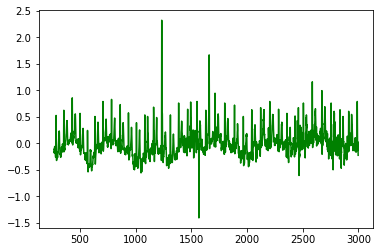

In [33]:
ecg = vitaldb.load_trk('395df4819e4e1f0d123d14f042667975f5945504', 0.01)

import matplotlib.pyplot as plt
plt.plot(ecg[:3000], color='g')

## 여러 트랙을 한번에 로딩

In [34]:
# 1번 case의 NIBP_SBP, NIBP_MBP, NIBP_DBP 트랙을 로딩
caseid = 1
sbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_SBP')]['tid'].values[0]
mbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_MBP')]['tid'].values[0]
dbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_DBP')]['tid'].values[0]
print(sbp_tid)
print(mbp_tid)
print(dbp_tid)
vals = vitaldb.load_trks([sbp_tid, mbp_tid, dbp_tid], 60)
vals

eb1e6d9a963d7caab8f00993cd85bf31931b7a32
29cef7b8fe2cc84e69fd143da510949b3c271314
829134dd331e867598f17d81c1b31f5be85dddec


array([[ nan,  nan,  nan],
       [150., 100.,  84.],
       [177., 109.,  75.],
       [178.,  96.,  74.],
       [172., 102.,  77.],
       [172., 102.,  77.],
       [172., 134.,  85.],
       [125.,  74.,  60.],
       [107.,  76.,  65.],
       [107.,  76.,  65.],
       [107., 153.,  65.],
       [199., 145., 100.],
       [199., 145., 100.],
       [199., 145., 100.]])